In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as colors
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import scipy as sp
from sklearn import datasets
import matplotlib.pyplot as mpl
mpl.rcParams["figure.figsize"] = (20,15)
mpl.rcParams['font.size'] = 12
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
import hdbscan
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = datasets.load_wine()

In [5]:
y = pd.DataFrame(data['target'],columns=['class'])
X = pd.DataFrame(data.data,columns=data.feature_names)

In [6]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [7]:
# df = X.merge(y,left_on=X.index,right_on=y.index).drop(columns=['key_0'])
# df.head()
# df.to_csv('wine.csv',index=False)

In [8]:
X.shape

(178, 13)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
std_clf = StandardScaler()
X_train_scaled = std_clf.fit_transform(X_train)
X_test_scaled = std_clf.transform(X_test)

In [11]:
X_train_scaled.shape

(142, 13)

In [12]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = X_train_scaled.shape[1]
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_scaled_PCA = pca.fit_transform(X_train_scaled)
X_train_scaled_PCA = pd.DataFrame(data=X_train_scaled_PCA, index=X_train.index)

In [13]:
X_test_scaled_PCA = pca.transform(X_test_scaled)
X_test_scaled_PCA = pd.DataFrame(data=X_test_scaled_PCA, index=X_test.index)

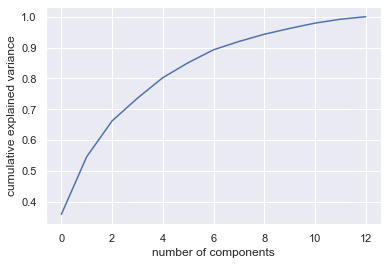

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [15]:
X_train_scaled_PCA_Selected = X_train_scaled_PCA.loc[:,:5] # as top 6 components nearly cover the 90% variance
X_test_scaled_PCA_Selected = X_test_scaled_PCA.loc[:,:5]

In [16]:
def optimize_k_means(X, max_k):
    means = []
    inertias = []
    
#     overallAccuracy_kMeansDF = \
#         pd.DataFrame(data=[],index=range(max_k+1),columns=['overallAccuracy'])
    
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        means.append(k)
        inertias.append(kmeans.inertia_)
        X_train_kmeansClustered = kmeans.predict(X)
        X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X.index, \
                     columns=['cluster'])
        
        
#         countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
#         accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
#         = analyzeCluster(X_train_kmeansClustered, y_train)
        
#         overallAccuracy_kMeansDF.loc[k] = overallAccuracy_kMeans
        
        
    fig, ax = plt.subplots(1,1,figsize=(40, 20))
    
    ax.plot(means, inertias, 'o-')
    ax.set_xlabel("Number of Clusters",fontweight="bold", size=20)
    ax.set_ylabel("Inertia",fontweight="bold", size=20)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=15) 
    ax.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    ax.set_title("Inertia vs. num Clusters",fontweight="bold",size=40)
    
    
    
#     ax[1].plot(overallAccuracy_kMeansDF.index,overallAccuracy_kMeansDF['overallAccuracy'],'o-')
#     ax[1].set_xlabel("Number of Clusters",fontweight="bold", size=20)
#     ax[1].set_ylabel("Overall Accuracy",fontweight="bold", size=20)
#     ax[1].tick_params(axis='both', which='major', labelsize=15)
#     ax[0].tick_params(axis='both', which='minor', labelsize=15) 
#     ax[1].grid(color = 'green', linestyle = '--', linewidth = 0.5)
#     ax[1].set_title("Accuracy vs. num Clusters",fontweight="bold",size=40)
    
    plt.show()

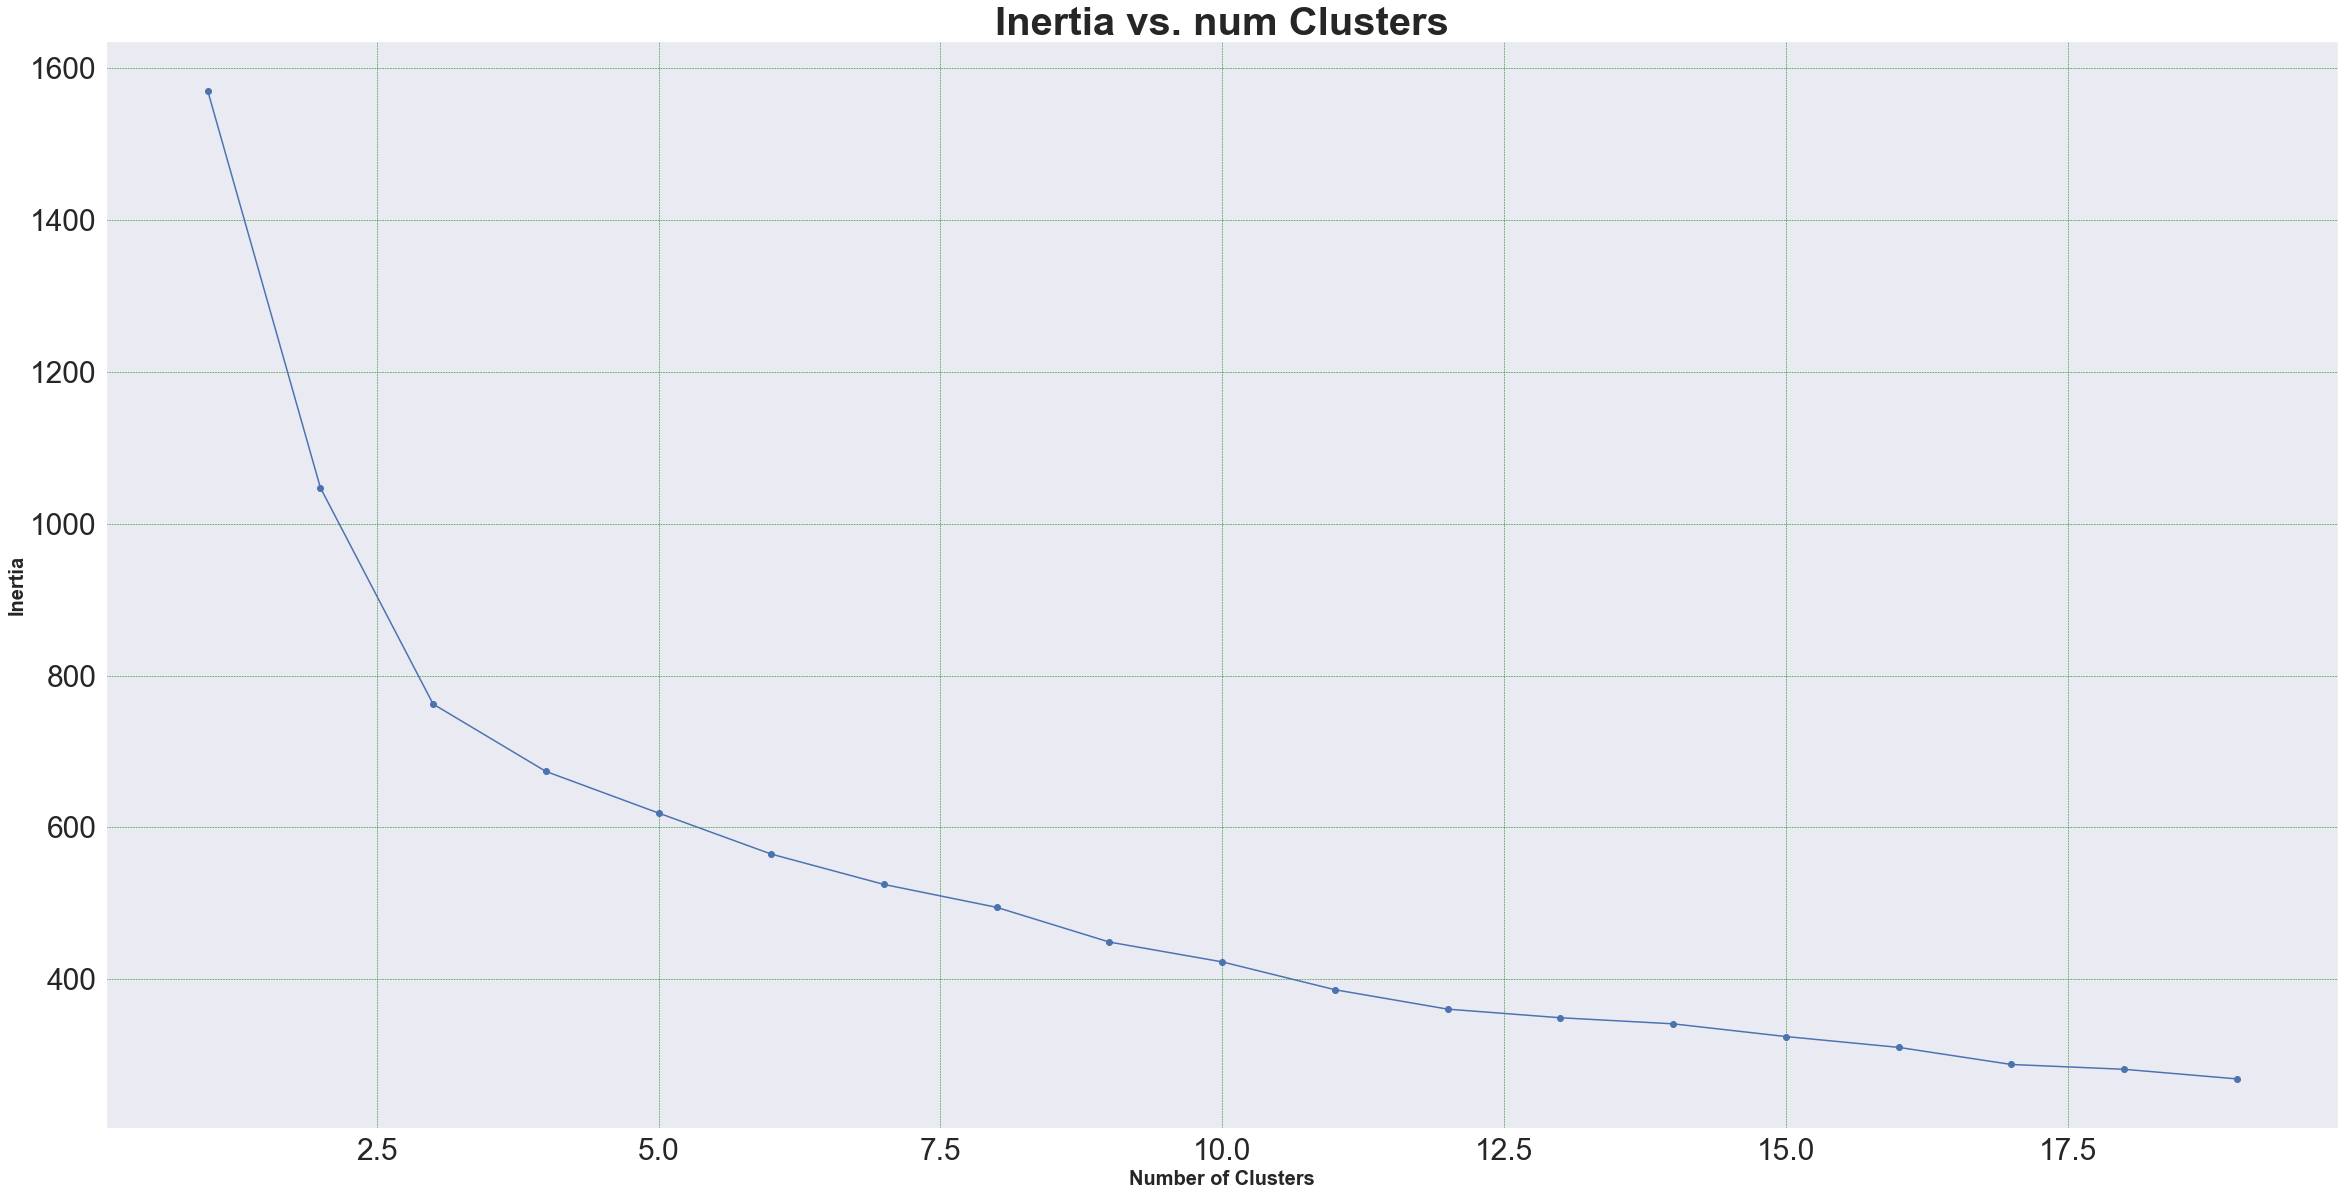

In [17]:
optimize_k_means(X_train_scaled_PCA_Selected, 20)

We are looking for the elbow of the plot. Based on the above plot, the elbow seems to appear at a value 3.

In [18]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

In [19]:
overallAccuracy_kMeansDF = \
        pd.DataFrame(data=[],index=range(2,5,1),columns=['overallAccuracy'])

def measure_kmeans_accuracy(n):
    # Create the KMeans model with the selected number of clusters
    kmeans = KMeans(n_clusters=n)

    # Fit the model to our dataset
    kmeans.fit(X_train_scaled_PCA_Selected)

    # Assign the data back to the workingdf
    X_train.loc[:,'KMeans'] = kmeans.labels_
    print(pd.crosstab(X_train['KMeans'],y_train['class']))

    X_train_kmeansClustered = kmeans.predict(X_train_scaled_PCA_Selected)
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                    index=X_train.index, columns=['cluster'])

    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train['class'])

    print("Overall accuracy for clusters: {} from K-Means: {} ".format(n, overallAccuracy_kMeans))

    print("Cluster results for K-Means")
    countByCluster_kMeans

    # Make predictions on train set and calculate adjusted Rand index
    ars = adjusted_rand_score(y_train['class'].values,X_train['KMeans'].values)
    print("Adjusted Rand Index:", ars)
    print("*"*40)

In [20]:
for i in range(2,5,1):
    measure_kmeans_accuracy(i)

class    0   1   2
KMeans            
0        0  14  40
1       45  43   0
Overall accuracy for clusters: 2 from K-Means: 0.5985915492957746 
Cluster results for K-Means
Adjusted Rand Index: 0.3913764487340102
****************************************
class    0   1   2
KMeans            
0        0  52   0
1        0   2  40
2       45   3   0
Overall accuracy for clusters: 3 from K-Means: 0.9647887323943662 
Cluster results for K-Means
Adjusted Rand Index: 0.8919536738815037
****************************************
class    0   1   2
KMeans            
0        0  34   0
1        4  22   0
2        0   1  40
3       41   0   0
Overall accuracy for clusters: 4 from K-Means: 0.9647887323943662 
Cluster results for K-Means
Adjusted Rand Index: 0.738634742726141
****************************************


#### Looking at the above, we will choose 3 clusters. Now, we will evaluate against the test data

In [21]:
# Create the KMeans model with the selected number of clusters
kmeans = KMeans(n_clusters=3)

# Fit the model to our dataset
kmeans.fit(X_train_scaled_PCA_Selected)

kmeans_labels = kmeans.predict(X_train_scaled_PCA_Selected)

# Assign the data back to the workingdf
X_train.loc[:,'KMeans'] = kmeans_labels
print("\n Cross Tab of the training data")
print(pd.crosstab(X_train['KMeans'],y_train['class']))

X_test_kmeansClustered = kmeans.predict(X_test_scaled_PCA_Selected)

# Assign the data back to the workingdf
X_test.loc[:,'KMeans'] = X_test_kmeansClustered
print("\n Cross Tab of the test data")
print(pd.crosstab(X_test['KMeans'],y_test['class']))

X_test_kmeansClustered = pd.DataFrame(data=X_test_kmeansClustered, \
                                index=X_test.index, columns=['cluster'])
    
countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_test_kmeansClustered, y_test)

print("Overall accuracy from K-Means: ",overallAccuracy_kMeans)

print("Cluster results for K-Means")
countByCluster_kMeans

# Make predictions on train set and calculate adjusted Rand index
kmean_test_ars = adjusted_rand_score(y_test['class'].values,X_test['KMeans'].values)
print("Adjusted Rand Index:", kmean_test_ars)
print("*"*40)


 Cross Tab of the training data
class    0   1   2
KMeans            
0        0  52   0
1        0   2  40
2       45   3   0

 Cross Tab of the test data
class    0   1  2
KMeans           
0        0  13  0
1        0   1  8
2       14   0  0
Overall accuracy from K-Means:  0.9722222222222222
Cluster results for K-Means
Adjusted Rand Index: 0.9245508982035928
****************************************


### Gaussian Mixure Model clustering

In [22]:
def optimize_gmm(X, max_comp):
    gmms = []
    bics = []
    aics = []
    
#     overallAccuracy_kMeansDF = \
#         pd.DataFrame(data=[],index=range(max_k+1),columns=['overallAccuracy'])
    
    
    for k in range(1,max_comp):
        gmm = GaussianMixture(n_components=k,covariance_type='full', random_state=42)
        gmm.fit(X)
        gmms.append(k)
        bics.append(gmm.bic(X))
        aics.append(gmm.aic(X))
        
        X_train_kmeansClustered = kmeans.predict(X)
        X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X.index, \
                     columns=['cluster'])
        
        
#         countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
#         accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
#         = analyzeCluster(X_train_kmeansClustered, y_train)
        
#         overallAccuracy_kMeansDF.loc[k] = overallAccuracy_kMeans
        
        
    fig, ax = plt.subplots(2,1,figsize=(40, 20))
    
    ax[0].plot(gmms, bics, 'o-')
    ax[0].set_xlabel("Number of Clusters",fontweight="bold", size=20)
    ax[0].set_ylabel("Inertia",fontweight="bold", size=20)
    ax[0].tick_params(axis='both', which='major', labelsize=30)
    ax[0].tick_params(axis='both', which='minor', labelsize=15) 
    ax[0].grid(color = 'green', linestyle = '--', linewidth = 0.5)
    ax[0].set_title("BIC vs. num Clusters",fontweight="bold",size=40)
    
    
    
    ax[1].plot(gmms, aics, 'o-')
    ax[1].set_xlabel("Number of Clusters",fontweight="bold", size=20)
    ax[1].set_ylabel("Overall Accuracy",fontweight="bold", size=20)
    ax[1].tick_params(axis='both', which='major', labelsize=30)
    ax[0].tick_params(axis='both', which='minor', labelsize=15) 
    ax[1].grid(color = 'green', linestyle = '--', linewidth = 0.5)
    ax[1].set_title("AIC vs. num Clusters",fontweight="bold",size=40)
    
    plt.show()

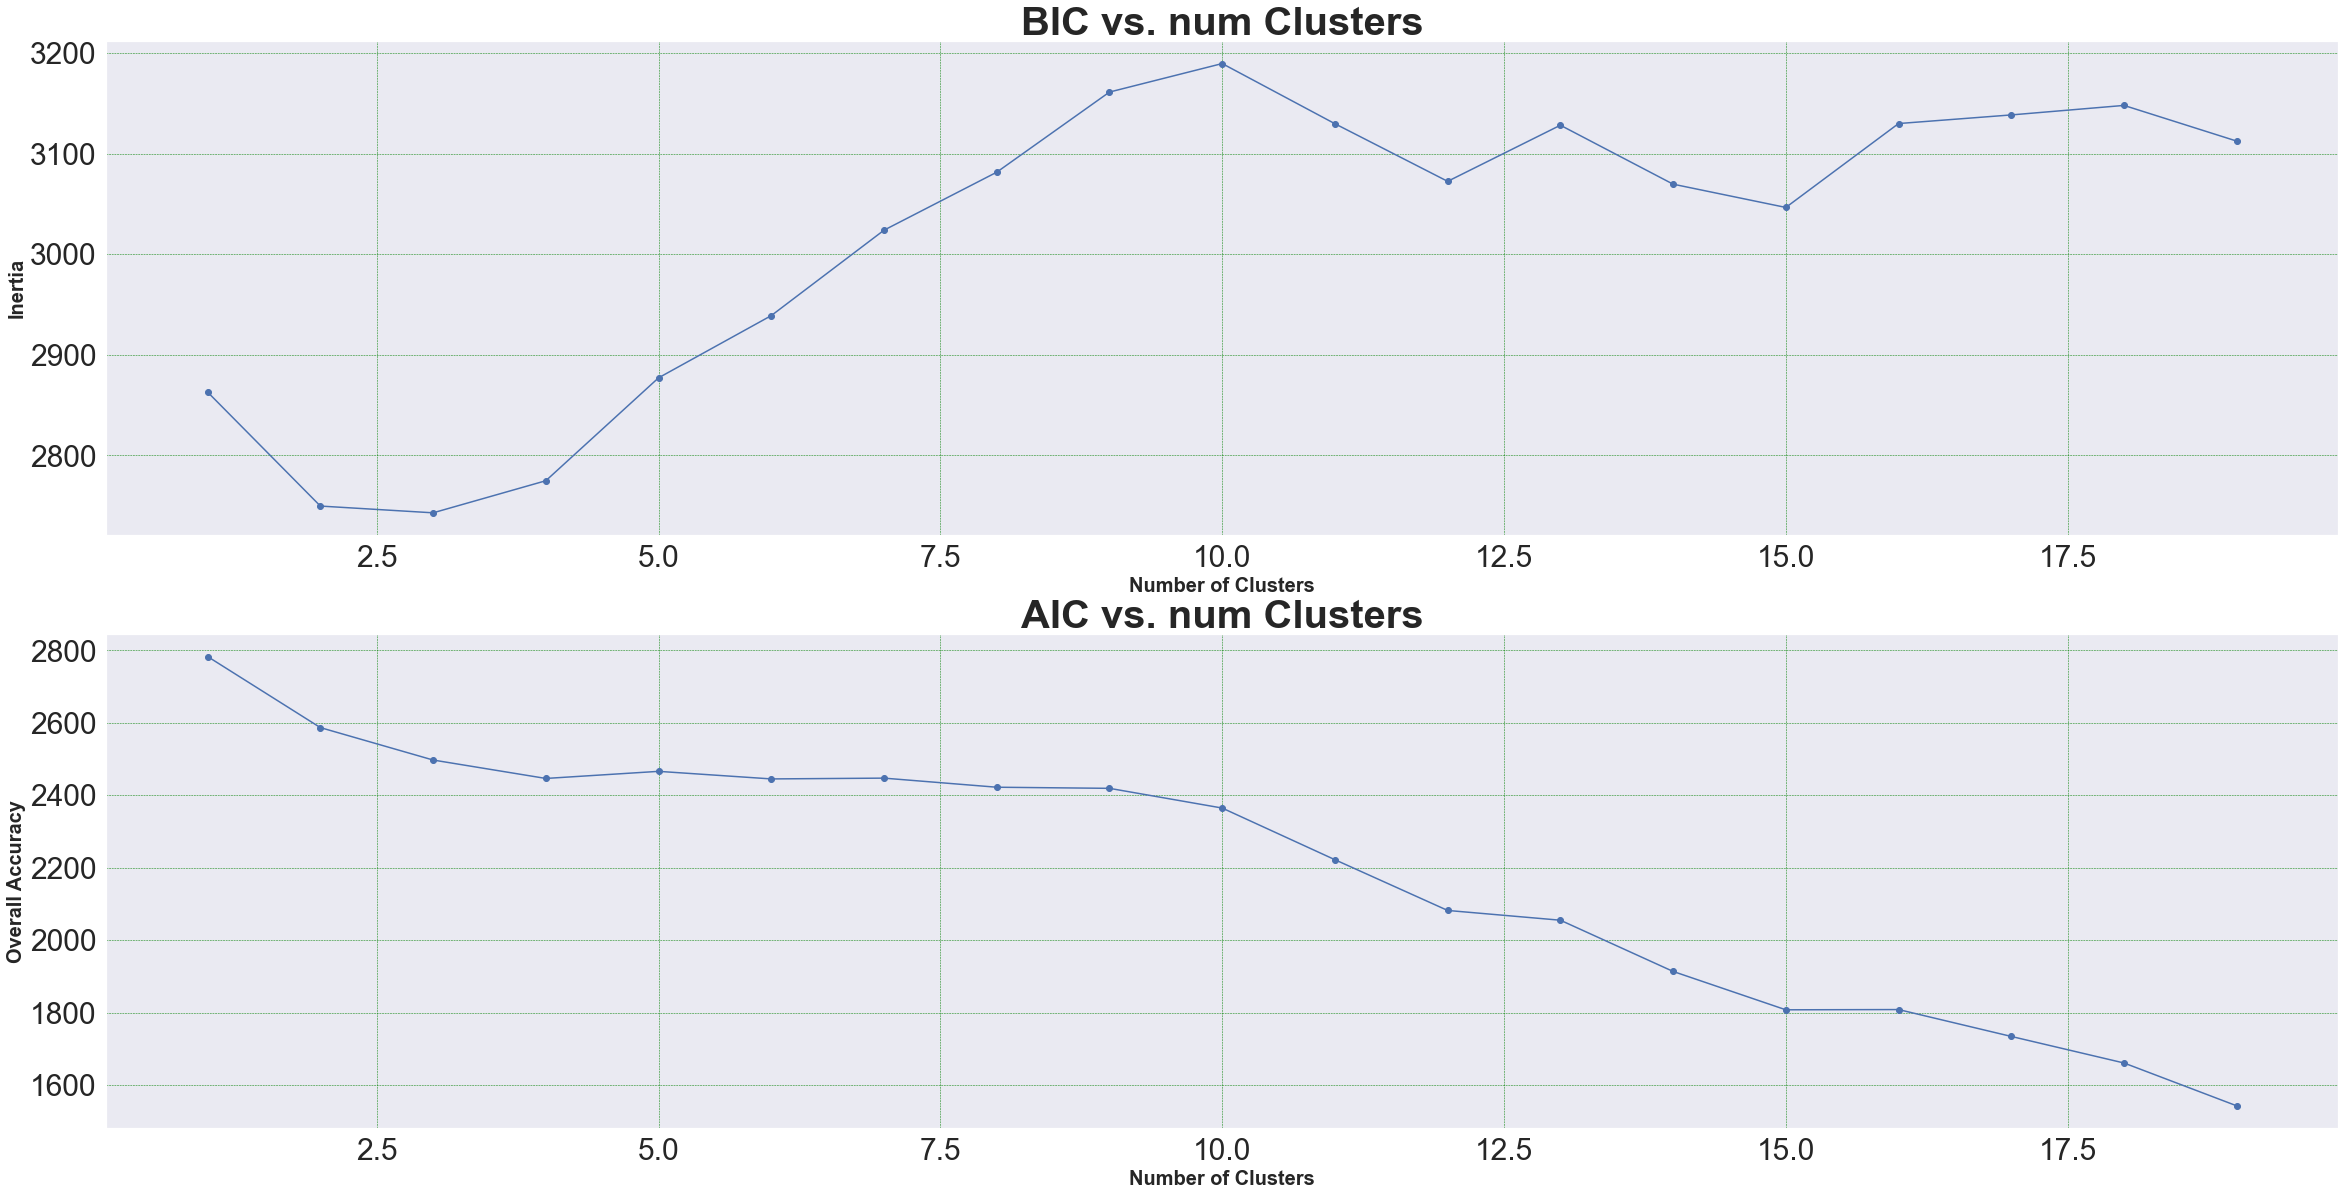

In [23]:
optimize_gmm(X_train_scaled_PCA_Selected, 20)

The optimal number of clusters (K) is the value that minimizes the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Based on BIC, we will go with either two or three clusters.

In [24]:
overallAccuracy_gmmDF = \
        pd.DataFrame(data=[],index=range(2,4,1),columns=['overallAccuracy'])

def measure_gmm_accuracy(n):
    # Create the KMeans model with the selected number of clusters
    gmm = GaussianMixture(n_components=n,covariance_type='full', random_state=42)

    # Fit the model to our dataset
    gmm.fit(X_train_scaled_PCA_Selected)
    
    # Predict the labels
    gmm_labels = gmm.predict(X_train_scaled_PCA_Selected)

    # Assign the data back to the workingdf
    X_train.loc[:,'gmms'] = gmm_labels
    print(pd.crosstab(X_train['gmms'],y_train['class']))

    X_train_gmmsClustered = gmm.predict(X_train_scaled_PCA_Selected)
    X_train_gmmsClustered = pd.DataFrame(data=X_train_gmmsClustered, \
                                    index=X_train.index, columns=['cluster'])

    countByCluster_gmms, countByLabel_gmms, countMostFreq_gmms, \
        accuracyDF_gmms, overallAccuracy_gmms, accuracyByLabel_gmms \
        = analyzeCluster(X_train_gmmsClustered, y_train['class'])

    print("Overall accuracy for clusters: {} from GMMs: {} ".format(n, overallAccuracy_gmms))

    print("Cluster results for GMMs")
    countByCluster_gmms

    # Make predictions on train set and calculate adjusted Rand index
    ars = adjusted_rand_score(y_train['class'].values,X_train['gmms'].values)
    print("Adjusted Rand Index:", ars)
    print("*"*40)

In [25]:
for i in range(2,4,1):
    measure_gmm_accuracy(i)

class   0   1   2
gmms             
0       0  17  40
1      45  40   0
Overall accuracy for clusters: 2 from GMMs: 0.5985915492957746 
Cluster results for GMMs
Adjusted Rand Index: 0.37525579455387176
****************************************
class   0   1   2
gmms             
0       0   3  40
1      43   0   0
2       2  54   0
Overall accuracy for clusters: 3 from GMMs: 0.9647887323943662 
Cluster results for GMMs
Adjusted Rand Index: 0.893320133892832
****************************************


#### Looking at the above, we will choose 3 clusters. Now, we will evaluate against the test data

In [26]:
# Create the KMeans model with the selected number of clusters
gmm = GaussianMixture(n_components=3,covariance_type='full', random_state=42)

# Fit the model to our dataset
gmm.fit(X_train_scaled_PCA_Selected)

gmm_labels = gmm.predict(X_train_scaled_PCA_Selected)

# Assign the data back to the workingdf
X_train.loc[:,'gmms'] = gmm_labels
print("\n Cross Tab of the training data")
print(pd.crosstab(X_train['gmms'],y_train['class']))

X_test_gmmsClustered = gmm.predict(X_test_scaled_PCA_Selected)

# Assign the data back to the workingdf
X_test.loc[:,'gmms'] = X_test_gmmsClustered
print("\n Cross Tab of the test data")
print(pd.crosstab(X_test['gmms'],y_test['class']))

X_test_gmmsClustered = pd.DataFrame(data=X_test_gmmsClustered, \
                                index=X_test.index, columns=['cluster'])
    
countByCluster_gmms, countByLabel_gmms, countMostFreq_gmms, \
    accuracyDF_gmms, overallAccuracy_gmms, accuracyByLabel_gmms \
    = analyzeCluster(X_test_gmmsClustered, y_test)

print("Overall accuracy from GMMs: ",overallAccuracy_gmms)

print("Cluster results for GMMs")
countByCluster_gmms

# Make predictions on train set and calculate adjusted Rand index
gmm_test_ars = adjusted_rand_score(y_test['class'].values,X_test['gmms'].values)
print("Adjusted Rand Index:", gmm_test_ars)
print("*"*40)


 Cross Tab of the training data
class   0   1   2
gmms             
0       0   3  40
1      43   0   0
2       2  54   0

 Cross Tab of the test data
class   0   1  2
gmms            
0       0   0  8
1      13   0  0
2       1  14  0
Overall accuracy from GMMs:  0.9722222222222222
Cluster results for GMMs
Adjusted Rand Index: 0.9036860879904876
****************************************


### DBSCAN

**minPts**

minPts is selected based on the domain knowledge. If you do not have domain understanding, a rule of thumb is to derive minPts from the number of dimensions D in the data set. minPts >= D + 1. For 2D data, take minPts = 4. For larger datasets, with much noise, it suggested to go with minPts = 2 * D.

**eps**

we must provide a value for epsilon which defines the maximum distance between two points. In layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

In our case, we have 6 dimensions, so we will choose minPts between 8 and 12

In [27]:
def find_eps(X,n_neighbors=4):
    nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    nearest_neighbors.fit(X)
    distances, indices = nearest_neighbors.kneighbors(X) #For every point in dataset, compute the distance of it's 8th nearest neighbor
    print(distances.shape)
    distances = np.sort(distances, axis=0)[:,1] # sort distances in the increaseing order
    plt.plot(distances)
    plt.show()

(142, 8)


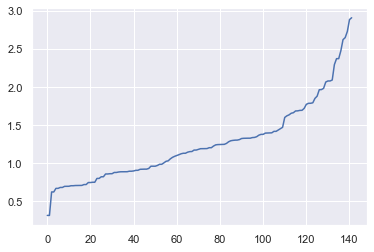

In [28]:
find_eps(X_train_scaled_PCA_Selected,n_neighbors=8)

From the list above, we will choose the distance where we see a sudden increase in distance i.e. between 1.5 and 1.6

In [29]:
overallAccuracy_dbscanDF = \
        pd.DataFrame(data=[],index=range(2,4,1),columns=['overallAccuracy'])

def measure_dbscan_accuracy(eps,minPts):
    eps  =  eps/100
    
    print("DBSCAN starting with minPts = {} and eps = {}".format(minPts,eps))
    # Create the KMeans model with the selected number of clusters
    db = DBSCAN(eps=eps, min_samples=minPts)

    # Fit the model to our dataset
    db.fit(X_train_scaled_PCA_Selected)
    
    # Predict the labels
    db_labels = db.labels_

    # Assign the data back to the workingdf
    X_train.loc[:,'db'] = db_labels
    print(pd.crosstab(X_train['db'],y_train['class']))
    
    num_clust = len(np.unique(db_labels) )

    X_train_dbClustered = db.fit_predict(X_train_scaled_PCA_Selected)
    X_train_dbClustered = pd.DataFrame(data=X_train_dbClustered, \
                                    index=X_train.index, columns=['cluster'])

    countByCluster_db, countByLabel_db, countMostFreq_db, \
        accuracyDF_db, overallAccuracy_db, accuracyByLabel_db \
        = analyzeCluster(X_train_dbClustered, y_train['class'])

    print("Overall accuracy for clusters: {} from DBSCAN: {} ".format(num_clust, overallAccuracy_db))

    print("Cluster results for DBSCAN")
    countByCluster_db

    # Make predictions on train set and calculate adjusted Rand index
    ars = adjusted_rand_score(y_train['class'].values,X_train['db'].values)
    print("Adjusted Rand Index:", ars)
    print("*"*40)

In [30]:
for eps in range(150,161,1):
    for minPts in range(8,13,1):
        measure_dbscan_accuracy(eps,minPts)

DBSCAN starting with minPts = 8 and eps = 1.5
class   0   1   2
db               
-1     11  47  30
 0     34   0   0
 1      0   9   0
 2      0   1  10
Overall accuracy for clusters: 4 from DBSCAN: 0.704225352112676 
Cluster results for DBSCAN
Adjusted Rand Index: 0.2924203151817021
****************************************
DBSCAN starting with minPts = 9 and eps = 1.5
class   0   1   2
db               
-1     12  48  40
 0     33   0   0
 1      0   9   0
Overall accuracy for clusters: 3 from DBSCAN: 0.6338028169014085 
Cluster results for DBSCAN
Adjusted Rand Index: 0.26450883079717047
****************************************
DBSCAN starting with minPts = 10 and eps = 1.5
class   0   1   2
db               
-1     13  57  40
 0     32   0   0
Overall accuracy for clusters: 2 from DBSCAN: 0.6267605633802817 
Cluster results for DBSCAN
Adjusted Rand Index: 0.27950535289317596
****************************************
DBSCAN starting with minPts = 11 and eps = 1.5
class   0   1   2
db 

class   0   1   2
db               
-1     14  46  40
 0     31   0   0
 1      0  11   0
Overall accuracy for clusters: 3 from DBSCAN: 0.6197183098591549 
Cluster results for DBSCAN
Adjusted Rand Index: 0.22755401587305646
****************************************
DBSCAN starting with minPts = 12 and eps = 1.55
class   0   1   2
db               
-1     14  57  40
 0     31   0   0
Overall accuracy for clusters: 2 from DBSCAN: 0.6197183098591549 
Cluster results for DBSCAN
Adjusted Rand Index: 0.26204289148439674
****************************************
DBSCAN starting with minPts = 8 and eps = 1.56
class   0   1   2
db               
-1      9  38  28
 0     36   0   0
 1      0  18   0
 2      0   1  12
Overall accuracy for clusters: 4 from DBSCAN: 0.7323943661971831 
Cluster results for DBSCAN
Adjusted Rand Index: 0.32630146733401333
****************************************
DBSCAN starting with minPts = 9 and eps = 1.56
class   0   1   2
db               
-1      9  42  31
 0     36

Overall accuracy for clusters: 3 from DBSCAN: 0.6267605633802817 
Cluster results for DBSCAN
Adjusted Rand Index: 0.24395052090032457
****************************************


We will choose eps = 1.56 and minPts = 8

In [31]:
eps = 1.56
min_samples = 8
leaf_size = 10
n_jobs = 4

In [32]:
def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

In [33]:
# Create the KMeans model with the selected number of clusters
db = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the model to our dataset
db.fit(X_train_scaled_PCA_Selected)

db_labels = db.labels_

# Assign the data back to the workingdf
X_train.loc[:,'dbs'] = db_labels
print("\n Cross Tab of the training data")
print(pd.crosstab(X_train['dbs'],y_train['class']))

X_test_dbsClustered = dbscan_predict(db,X_test_scaled_PCA_Selected)

# Assign the data back to the workingdf
X_test.loc[:,'dbs'] = X_test_dbsClustered
print("\n Cross Tab of the test data")
print(pd.crosstab(X_test['dbs'],y_test['class']))

X_test_dbsClustered = pd.DataFrame(data=X_test_dbsClustered, \
                                index=X_test.index, columns=['cluster'])
    
countByCluster_dbs, countByLabel_dbs, countMostFreq_dbs, \
    accuracyDF_dbs, overallAccuracy_dbs, accuracyByLabel_dbs \
    = analyzeCluster(X_test_dbsClustered, y_test)

print("Overall accuracy from DBS: ",overallAccuracy_dbs)

print("Cluster results for dbs")
countByCluster_dbs

# Make predictions on train set and calculate adjusted Rand index
dbscan_test_ars = adjusted_rand_score(y_test['class'].values,X_test['dbs'].values)
print("Adjusted Rand Index:", dbscan_test_ars)
print("*"*40)


 Cross Tab of the training data
class   0   1   2
dbs              
-1      9  38  28
 0     36   0   0
 1      0  18   0
 2      0   1  12

 Cross Tab of the test data
class   0   1  2
dbs             
-1     11  13  7
 0      3   1  1
Overall accuracy from DBS:  0.4444444444444444
Cluster results for dbs
Adjusted Rand Index: -0.007239819004524887
****************************************


#### HDBSCAN

In [34]:
plt.rcParams["figure.figsize"] = (20,15)
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

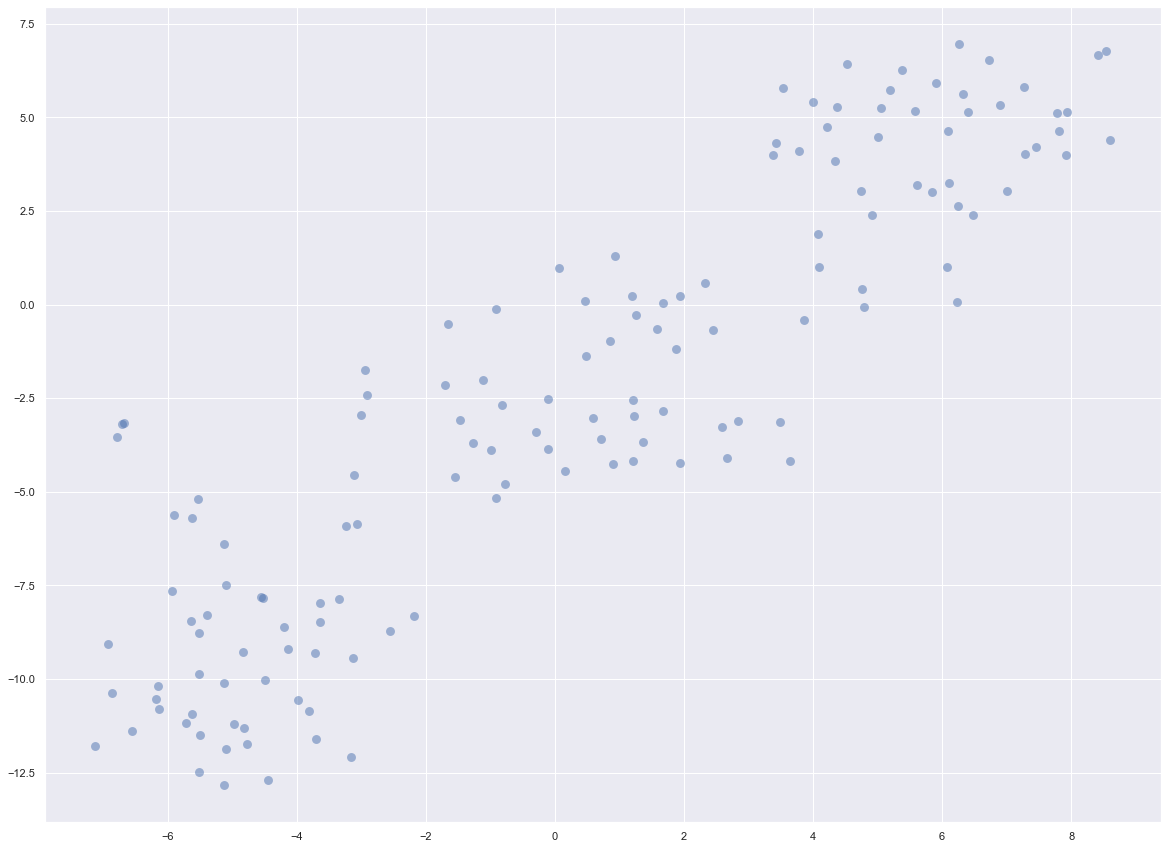

In [35]:
projection = TSNE().fit_transform(X_train_scaled_PCA_Selected)
plt.scatter(*projection.T, **plot_kwds)

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True).fit(X_train_scaled_PCA_Selected)
clusterer

HDBSCAN(gen_min_span_tree=True, min_cluster_size=3)

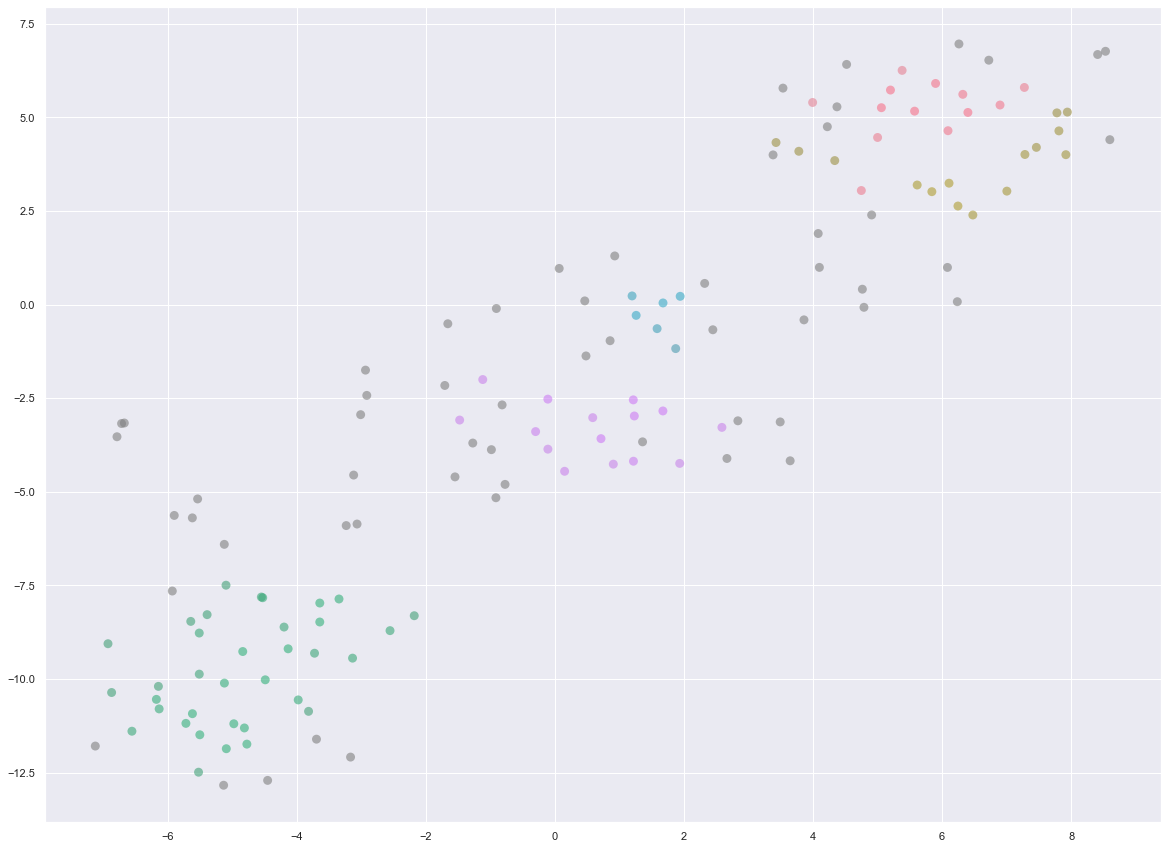

In [37]:
color_palette = sns.color_palette("husl", 5)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plot_kwds['c'] =  cluster_member_colors
plot_kwds['alpha'] = 0.6

plt.scatter(*projection.T, **plot_kwds)

In [38]:
labels = clusterer.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


<AxesSubplot:>

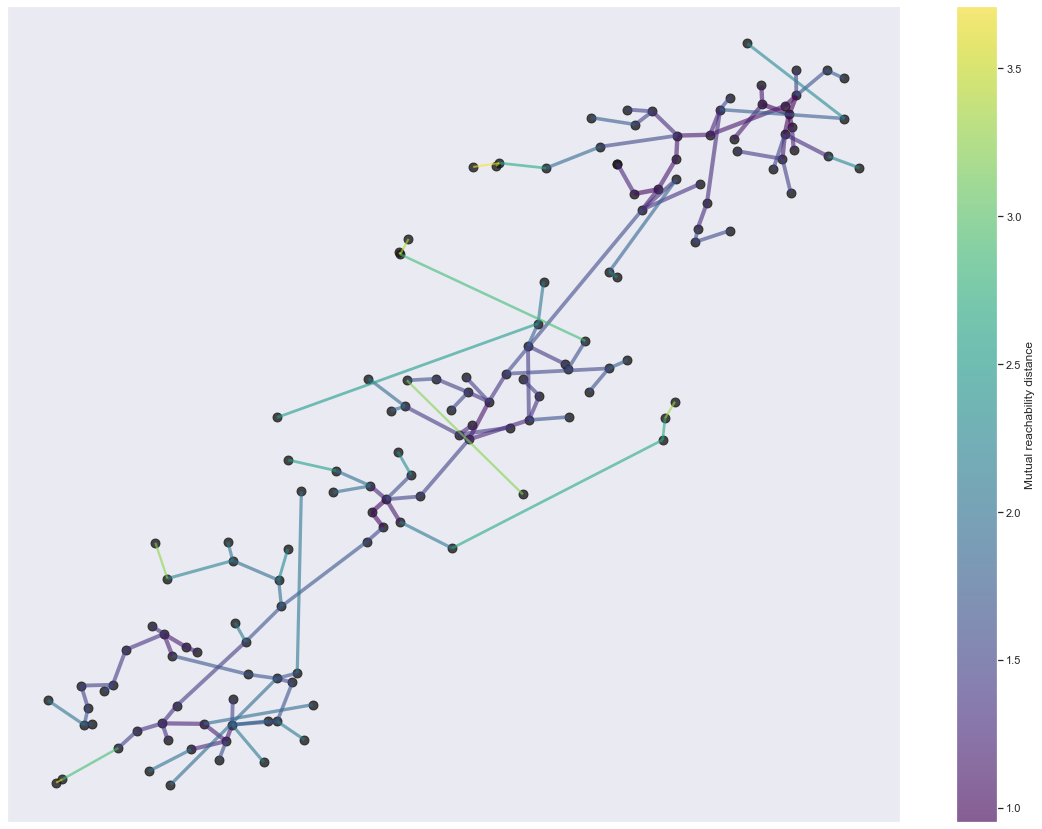

In [39]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

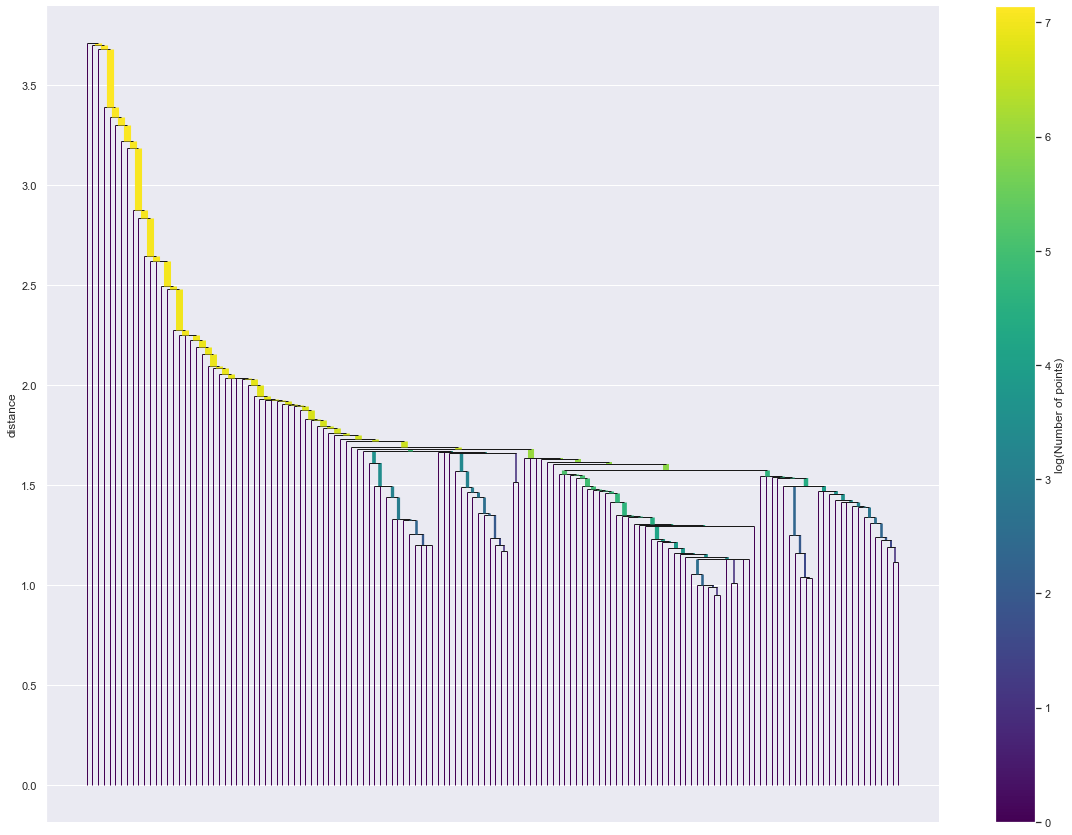

In [40]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

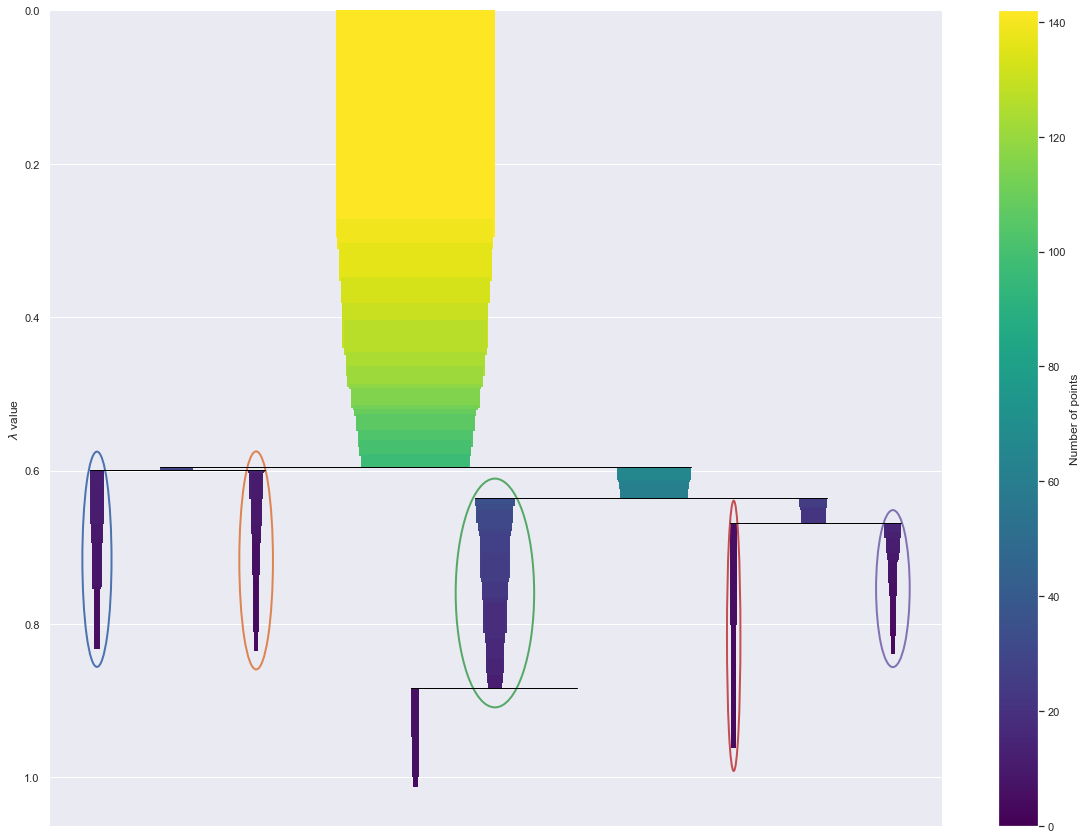

In [41]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

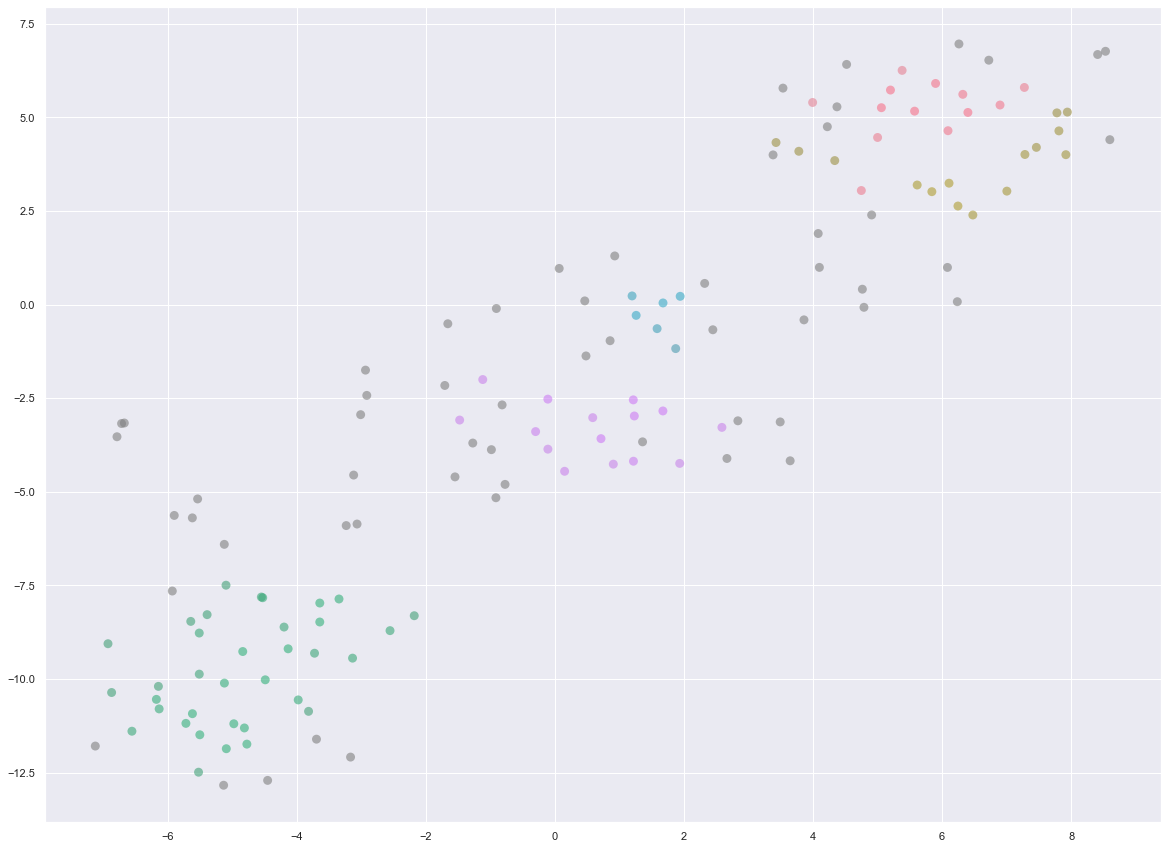

In [42]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(*projection.T, **plot_kwds)

#### From the above plot, we will choose the # of clusters such that
1. We will focus on persistence and breadth of the cluster
2. Once we choose a cluster, we can't choose it's descendants

In [43]:
def measure_hdbscan_accuracy(minClusterSize,minSamples,eps):
    eps  =  eps/100
    
    print("HDBSCAN starting with minClusterSize = {}, minSamples = {} and eps = {}".format(minClusterSize,minSamples,eps))
    # Create the HDBSCAN model with the selected number of clusters
    hdb = hdbscan.HDBSCAN(min_cluster_size=minClusterSize, \
        min_samples=minSamples, cluster_selection_epsilon=eps, \
        cluster_selection_method='eom')

    X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_scaled_PCA_Selected)

    X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

    countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
        = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)
    
    hdb_labels = hdb.labels_
    
    X_train.loc[:,'hdb'] = hdb_labels
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)


    print("Overall accuracy for clusters: {} from HDBSCAN: {} ".format(n_clusters_, overallAccuracy_hdbscan))

    print("Cluster results for HDBSCAN")
    countByCluster_hdbscan

    # Make predictions on train set and calculate adjusted Rand index
    ars = adjusted_rand_score(y_train['class'].values,X_train['hdb'].values)
    print("Adjusted Rand Index:", ars)
    print("*"*40)

In [44]:
min_cluster_size = range(5,15,5) # smallest size grouping within a proximity that you wish to consider a cluster. 
 # Rest of the points are considered noise.
min_samples = range(2,12,2) # this decides the noise level. 
eps = range(150,161,1)
for i in min_cluster_size:
    for j in min_samples:
        for k in eps:
            measure_hdbscan_accuracy(i,j,k)

HDBSCAN starting with minClusterSize = 5, minSamples = 2 and eps = 1.5
Estimated number of clusters: 4
Overall accuracy for clusters: 4 from HDBSCAN: 0.852112676056338 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.43923072793977225
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 2 and eps = 1.51
Estimated number of clusters: 4
Overall accuracy for clusters: 4 from HDBSCAN: 0.852112676056338 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.43923072793977225
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 2 and eps = 1.52
Estimated number of clusters: 4
Overall accuracy for clusters: 4 from HDBSCAN: 0.852112676056338 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.43923072793977225
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 2 and eps = 1.53
Estimated number of clusters: 4
Overall accuracy for clusters: 4 from HDBSCAN: 0.85211267

Adjusted Rand Index: 0.2130548454008582
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 8 and eps = 1.5
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.5492957746478874 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.18167460789257825
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 8 and eps = 1.51
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.5492957746478874 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.18167460789257825
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 8 and eps = 1.52
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.5492957746478874 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.18167460789257825
****************************************
HDBSCAN starting with minClusterSize = 5, minSamples = 8 and eps = 1.53
Estim

Cluster results for HDBSCAN
Adjusted Rand Index: 0.24717756569332328
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 4 and eps = 1.5
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.647887323943662 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.3037178108997707
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 4 and eps = 1.51
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.647887323943662 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.3037178108997707
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 4 and eps = 1.52
Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.647887323943662 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.3037178108997707
****************************************
HDBSCAN starting with minClusterSize = 10, minSampl

Estimated number of clusters: 2
Overall accuracy for clusters: 2 from HDBSCAN: 0.5492957746478874 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.18167460789257825
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 10 and eps = 1.5
Estimated number of clusters: 0
Overall accuracy for clusters: 0 from HDBSCAN: 0.4014084507042254 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.0
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 10 and eps = 1.51
Estimated number of clusters: 0
Overall accuracy for clusters: 0 from HDBSCAN: 0.4014084507042254 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.0
****************************************
HDBSCAN starting with minClusterSize = 10, minSamples = 10 and eps = 1.52
Estimated number of clusters: 0
Overall accuracy for clusters: 0 from HDBSCAN: 0.4014084507042254 
Cluster results for HDBSCAN
Adjusted Rand Index: 0.0
********************************

we will choose minClusterSize = 10, minSamples = 2 and eps = 1.5

In [45]:
minClusterSize = 10
minSamples = 2
eps = 1.5

In [46]:
# Create the KMeans model with the selected number of clusters
hdb = hdbscan.HDBSCAN(min_cluster_size=minClusterSize, \
        min_samples=minSamples, cluster_selection_epsilon=eps, \
        cluster_selection_method='eom', prediction_data=True)

# Fit the model to our dataset
hdb.fit_predict(X_train_scaled_PCA_Selected)

hdb_labels = hdb.labels_

# Assign the data back to the workingdf
X_train.loc[:,'hdb'] = hdb_labels
print("\n Cross Tab of the training data")
print(pd.crosstab(X_train['hdb'],y_train['class']))

#X_test_hdbClustered = dbscan_predict(db,X_test_scaled_PCA_Selected)

X_test_hdbClustered, strengths = hdbscan.approximate_predict(hdb, X_test_scaled_PCA_Selected)


# Assign the data back to the workingdf
X_test.loc[:,'hdb'] = X_test_hdbClustered
print("\n Cross Tab of the test data")
print(pd.crosstab(X_test['hdb'],y_test['class']))

X_test_hdbClustered = pd.DataFrame(data=X_test_hdbClustered, \
                                index=X_test.index, columns=['cluster'])
    
countByCluster_hdbscan, countByLabel_hdbscan, countMostFreq_hdbscan, \
    accuracyDF_hdbscan, overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_test_hdbClustered, y_test)

print("Overall accuracy from hdbscan: ",overallAccuracy_hdbscan)

print("Cluster results for hdb")
countByCluster_hdbscan

# Make predictions on train set and calculate adjusted Rand index
hdbscan_test_ars = adjusted_rand_score(y_test['class'].values,X_test['hdb'].values)
print("Adjusted Rand Index:", hdbscan_test_ars)
print("*"*40)


 Cross Tab of the training data
class   0   1   2
hdb              
-1      9  25  10
 0      0   2  14
 1      0   0  16
 2     36   0   0
 3      0  30   0

 Cross Tab of the test data
class   0  1  2
hdb            
-1      4  6  1
 0      0  0  4
 1      0  0  3
 2     10  0  0
 3      0  8  0
Overall accuracy from hdbscan:  0.8611111111111112
Cluster results for hdb
Adjusted Rand Index: 0.4485006518904824
****************************************


In [55]:
# Count top place finishes
ClusteringDF = pd.DataFrame(data=[],index=range(1,5), \
                            columns=["kMeansTest_ars", \
                                    "GMMTest_ars", \
                                    "dbscanTest_ars", \
                                    "hdbscanTest_ars"])


ClusteringDF.kMeansTest_ars = kmean_test_ars
ClusteringDF.GMMTest_ars = gmm_test_ars
ClusteringDF.dbscanTest_ars = dbscan_test_ars
ClusteringDF.hdbscanTest_ars = hdbscan_test_ars

tscResults = ClusteringDF.copy()

for i in range(0,len(tscResults)):
    maxValue = tscResults.iloc[i].max()
    tscResults.iloc[i][tscResults.iloc[i]==maxValue]=1
    minValue = tscResults .iloc[i].min()
    tscResults.iloc[i][tscResults.iloc[i]==minValue]=-1
    medianValue = tscResults.iloc[i].median()
    tscResults.iloc[i][tscResults.iloc[i]==medianValue]=0

In [56]:
tscResults[tscResults.index==1]

,kMeansTest_ars,GMMTest_ars,dbscanTest_ars,hdbscanTest_ars
1,0.924551,0.903686,-0.00724,0.448501
